
# NLP (Natural Language Processing)

## Get the Data

We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)
Our data is a collection of more than 5 thousand SMS phone messages. 

In [72]:
import pandas as pd
messages = pd.read_csv('../../data/sms_spam_ham.tsv', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!
With the exploratory analysis we need to start thinking about the features we are going to be using. [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is a very large part of spam detection in general.

In [73]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Message length could be a important feature. Let's make a new column to detect how long the text messages are:

In [74]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

<Axes: xlabel='length', ylabel='Count'>

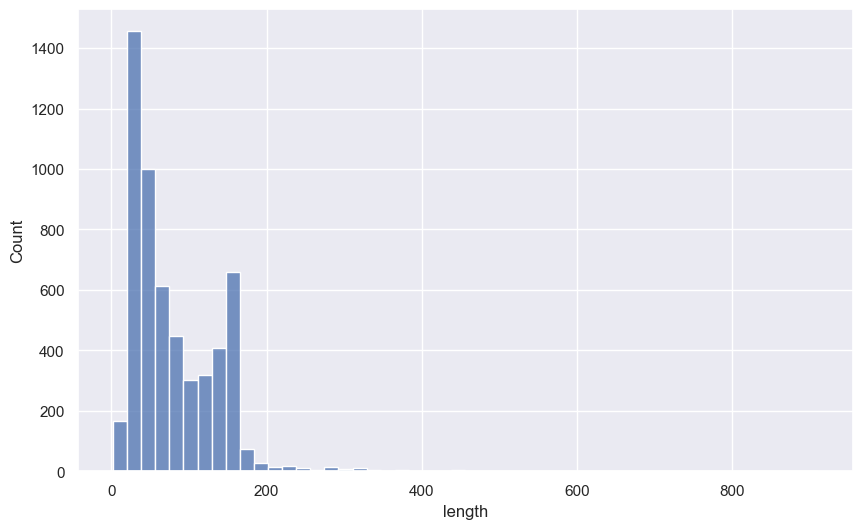

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
sns.histplot(messages['length'], bins=50)

Message length goes to almost 1000ish, suggesting there are some really long messages

In [76]:
messages.length.describe()
# Check the longest message
# messages[messages['length'] == 910]['message'].iloc[0]

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

<Axes: xlabel='length', ylabel='Count'>

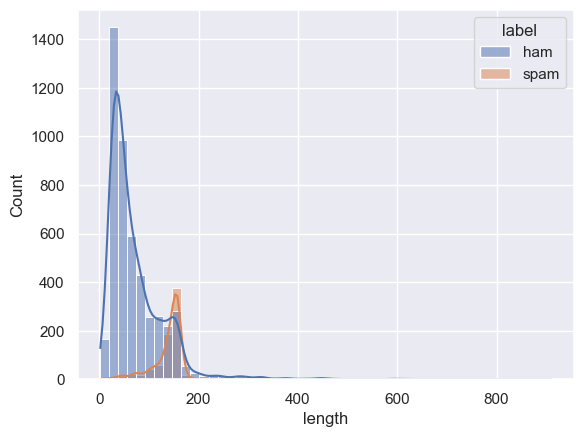

In [77]:
sns.set_theme(style="darkgrid")
sns.histplot(data=messages, x='length', hue='label', bins=50, kde=True)

The trend is that the spam messages tend to have more characters.

## Text Pre-processing

The classification algorithms we've used so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus(collection of text) to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

For example, here are two simple text documents:

(1) John likes to watch movies. Mary likes movies too.

(2) Mary also likes to watch football games.

Based on these two text documents, a list is constructed as follows for each document:

"John","likes","to","watch","movies","Mary","likes","movies","too"

"Mary","also","likes","to","watch","football","games"

BoW1 = {"John":1,"likes":2,"to":1,"watch":1,"movies":2,"Mary":1,"too":1}

BoW2 = {"Mary":1,"also":1,"likes":1,"to":1,"watch":1,"football":1,"games":1}


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers)

In [78]:
# Sample code to demonstrate text preprocessing:

import string
from nltk.corpus import stopwords
#   >>> import nltk
#   >>> nltk.download('stopwords')

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]
# Join the characters again to form the string.
nopunc = ''.join(nopunc)

# Now let's see how to remove stopwords. We can impot a list of english stopwords from NLTK 
# stopwords.words('english')[0:10] # Show some stop words
# output: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

nopunc.split()
# output: ['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
clean_mess


['Sample', 'message', 'Notice', 'punctuation']

Let's put above in a function to apply it to our DataFrame later on:

In [79]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

## Vectorization

Now we'll convert each message, represented as a list of tokens into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus(collection of texts).  We will **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
# Using the analyzer from the text_process function to remove stop words and punctuation
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [81]:
# Sample message to see how it works
message4 = messages['message'][3]
print(message4)
print('\n')
bow4 = bow_transformer.transform([message4])
print(bow4)
print('\n')
print(bow4.shape)


U dun say so early hor... U c already then say...


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 7 stored elements and shape (1, 11425)>
  Coords	Values
  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


(1, 11425)


Above means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [84]:
print(bow_transformer.get_feature_names_out()[4068])
print(bow_transformer.get_feature_names_out()[9554])

U
say


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. 

Let's go ahead and check out how the bag-of-words counts for the entire SMS collection is a large, sparse matrix:

In [ ]:
messages_bow = bow_transformer.transform(messages['message'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)
# How sparse is the matrix?
sparsity = (messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])) * 100
print(f"Sparsity: {sparsity:.2f}%")
# Over 99.9% of the matrix entries are zeros

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548
Sparsity: 0.08%


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### So what is TF-IDF?

**Term Frequency – Inverse Document Frequency**

It’s a numerical statistic that reflects how important a word is to a document in a collection

**Why not just count words?**

Using just word counts (like in CountVectorizer) has a problem:

Common words like “the”, “and”, “is” appear in nearly every document — they get high importance even though they aren't meaningful.

TF-IDF solves this by penalizing common words and highlighting rare-but-important ones.

**Formula**

* TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

* IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

**TF-IDF = TF × IDF**

So a word is important if:

* It appears frequently in a given doc (high TF)

* It appears rarely in the whole collection (high IDF)

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

* The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03 

Now, assume we have 10 million documents and the word cat appears in 1000 of these.  

* Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4 

Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12

Let's calculate TF-IDF for the sample message

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 11425)>
  Coords	Values
  (0, 4068)	0.4083258993338407
  (0, 4629)	0.2661980190608719
  (0, 5261)	0.2972995740586873
  (0, 6204)	0.2995379972369742
  (0, 6222)	0.31872168929491496
  (0, 7186)	0.4389365653379858
  (0, 9554)	0.5385626262927565


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [ ]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


To transform the entire bag-of-words collection into TF-IDF collection at once:

In [ ]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


## Training a model

With messages represented as vectors, we can finally train our spam/ham classifier. [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier algorithm is a good choice.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [ ]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham




## Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [ ]:
all_predictions = spam_detect_model.predict(messages_tfidf)
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



There are quite a few possible metrics for evaluating model performance. 

Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mis-predicting "spam" as "ham" is probably much lower than mis-predicting "ham" as "spam".

In the above "evaluation",we evaluated accuracy on the same data we used for training. **We should never actually evaluate on the same dataset we train on!**

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. 

We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [ ]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x11f499a80>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [ ]:
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1003
        spam       0.72      1.00      0.84       112

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115

